# Training notebook

In [39]:
import os  # for file operations
import json  # for loading the annotations file
from PIL import Image, ImageDraw, ImageOps  # for processing the image data
import numpy as np
from random import shuffle
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

## constants

In [40]:
DATA_PATH = "./data/"  # must contain multiple subdirectories - one for each class
ANNOTATIONS_PATH = "./via-annotations.json"  # relative to the notebook

BATCH_SIZE = 64
IMAGE_RESOLUTION = (224, 224)  # standard for VGG19
EPOCHS = 80

CLASS_NAMES = sorted([os.path.basename(f) for f in os.scandir(DATA_PATH) if f.is_dir()])  # automatically generated
CLASS_COUNT = len(CLASS_NAMES)

In [41]:
with open(ANNOTATIONS_PATH, "r") as via_data:
    via_annotations = json.load(via_data)

In [42]:
print(CLASS_NAMES)

['Glass, Brown Glass', 'Glass, Clear Glass', 'Glass, Clear Glass Shards', 'Glass, Green Glass', 'Glass, Green Glass Shards', 'Medical, Face Mask', 'Medical, Rubber Glove', 'Metal, Aluminium Can', 'Metal, Aluminium Foil and Packaging', 'Metal, Aluminium Pouch or Wrap', 'Metal, Tin Can', 'Organic, Food Waste', 'Other, Baby Food Pouch', 'Other, Cigarette Butt', 'Other, Cigarette Package', 'Other, Kitchen Sponge', 'Other, Rubber Balloon', 'Paper, Cardboard Box or Sheet', 'Paper, Cardboard Cup', 'Paper, Liquid Carton', 'Paper, Newspaper or Magazine', 'Paper, Paper Bag', 'Paper, Paper Straw', 'Paper, Pulp Egg Container', 'Paper, Small Cardboard Packaging', 'Paper, Stationery', 'Paper, Tissue Paper', 'Plastic, Bubble Wrap', 'Plastic, Clear PP Cup', 'Plastic, Clear PP Food Container', 'Plastic, Clear PS Cup', 'Plastic, Expanded Polystyrene', 'Plastic, HDPE Bottle', 'Plastic, HDPE Container', 'Plastic, LDPE Bag or Film', 'Plastic, LDPE Shopping Bag', 'Plastic, Nylon', 'Plastic, PET Bottle', 'Pl

## segmentation

  0%|          | 0/1559 [00:00<?, ?it/s]

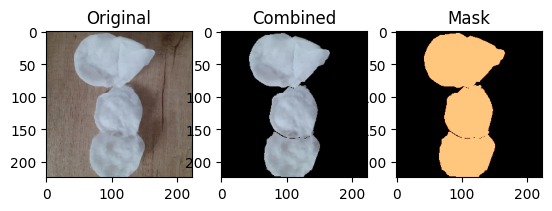

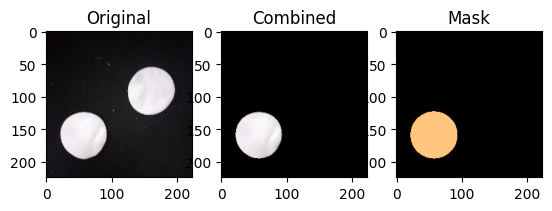

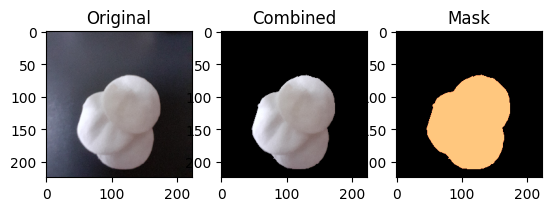

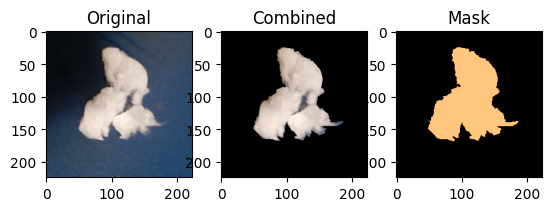

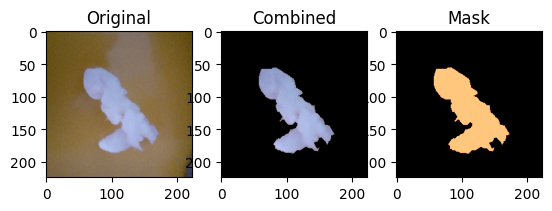

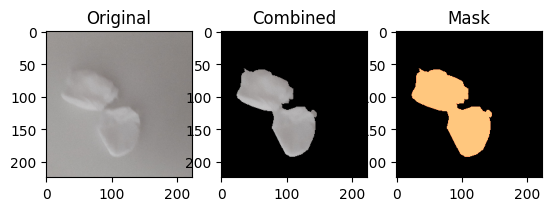

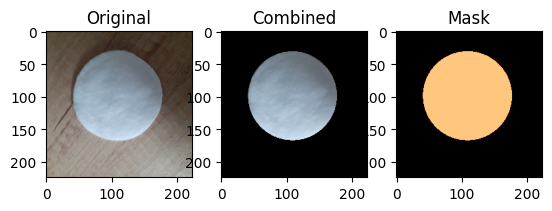

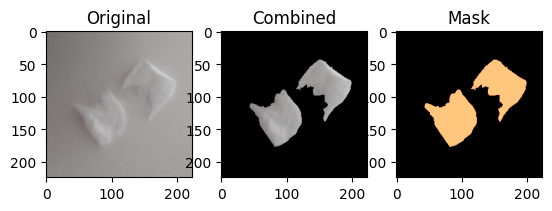

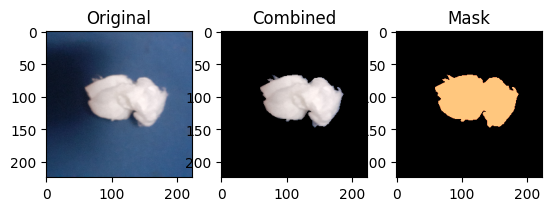

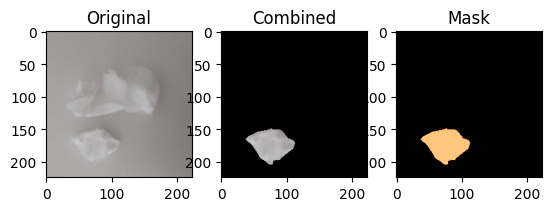

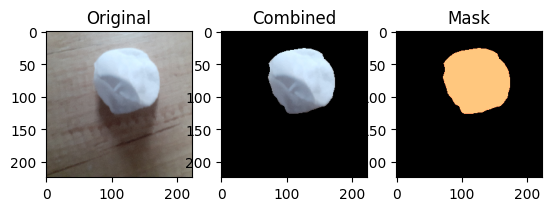

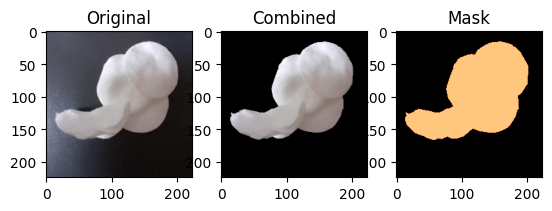

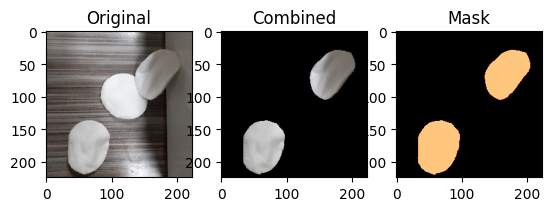

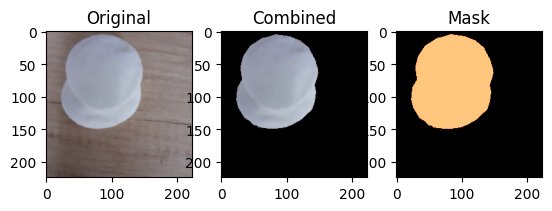

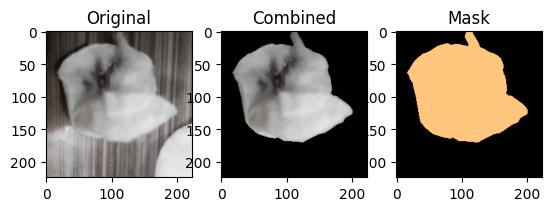

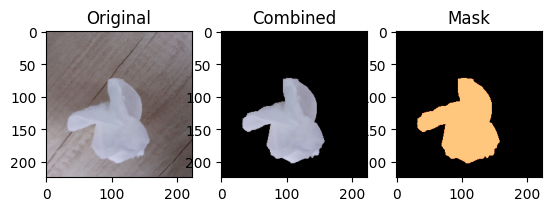

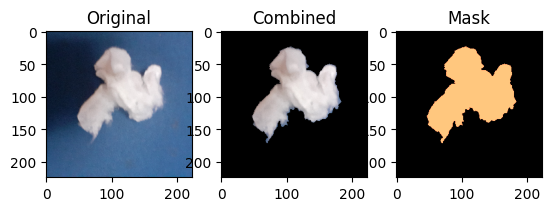

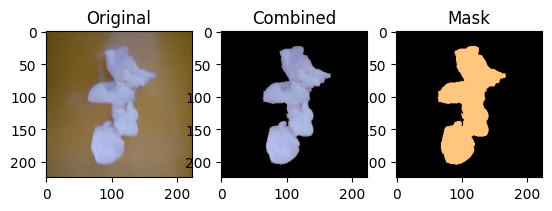

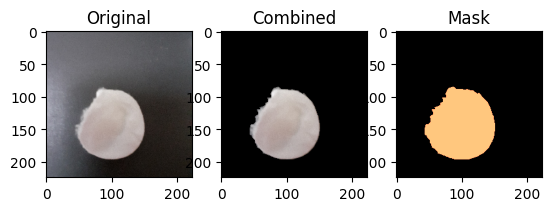

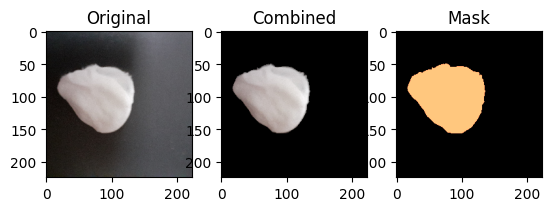

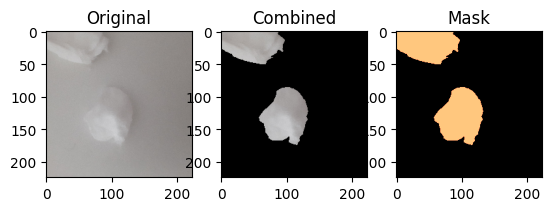

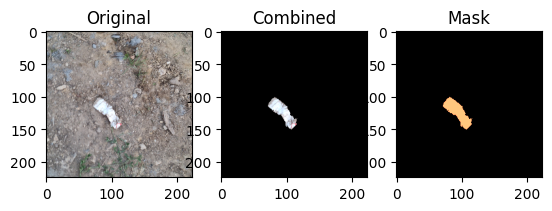

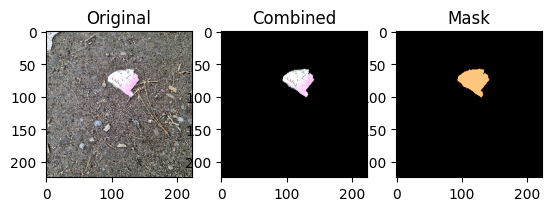

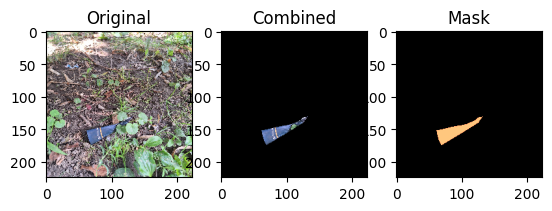

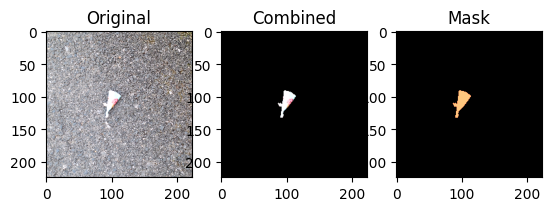

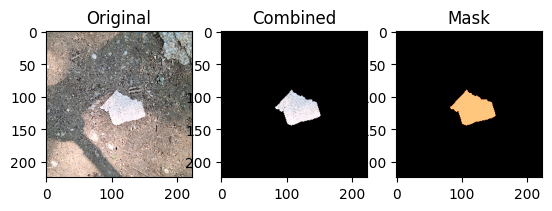

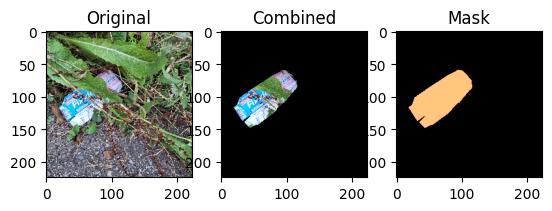

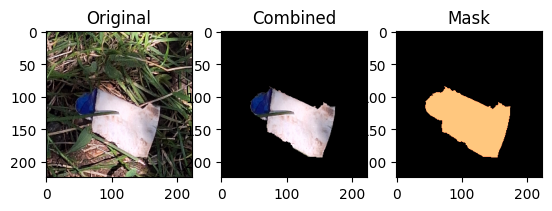

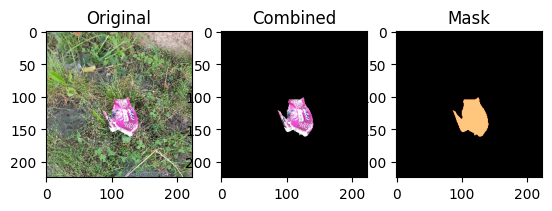

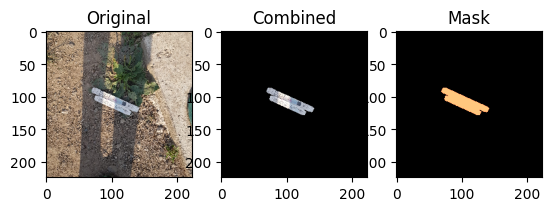

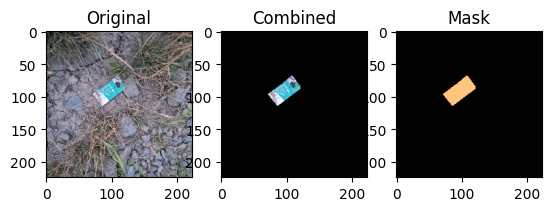

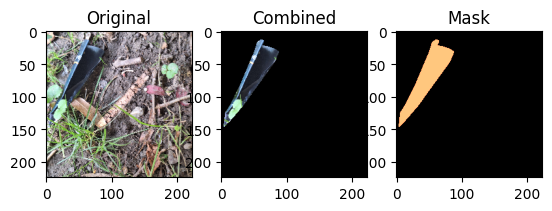

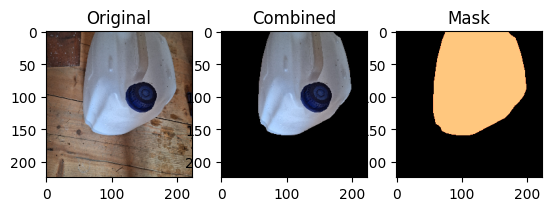

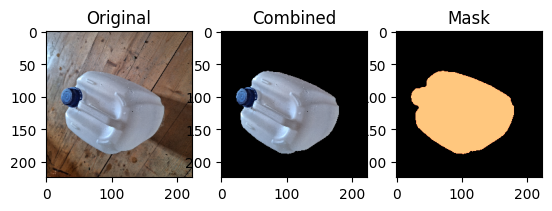

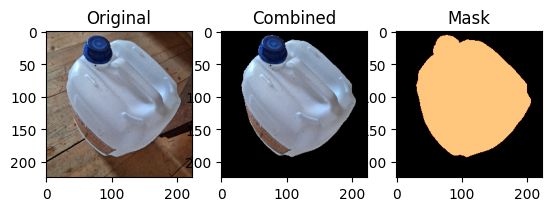

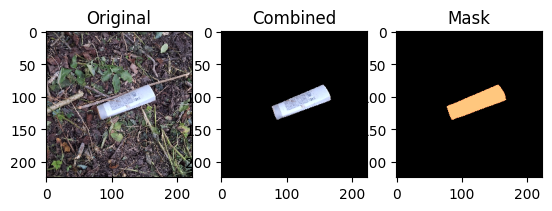

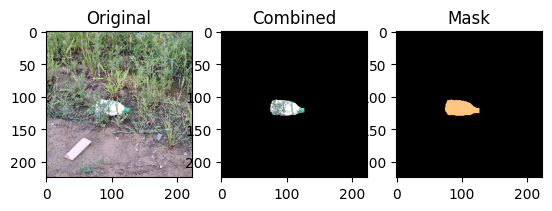

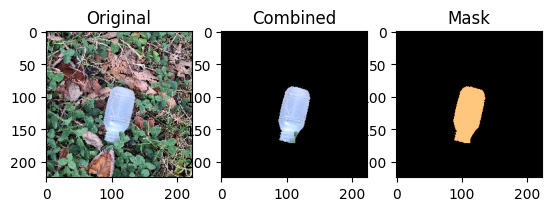

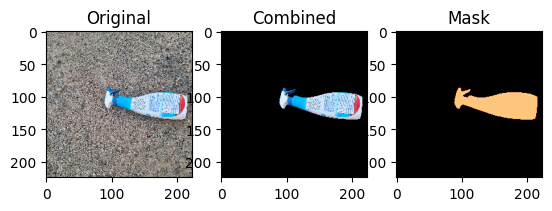

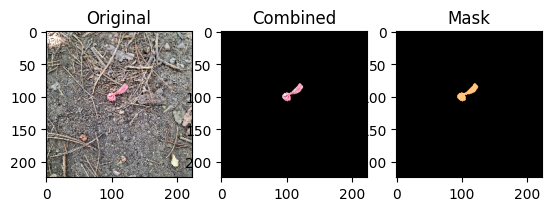

File not found: ./data/./Other, Rubber Balloon/original_20230804_110130.jpg. Skipping.


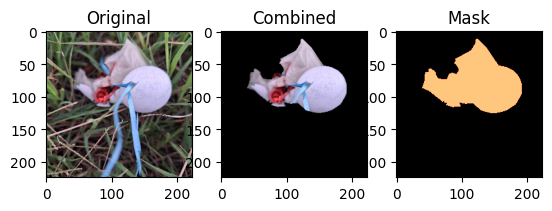

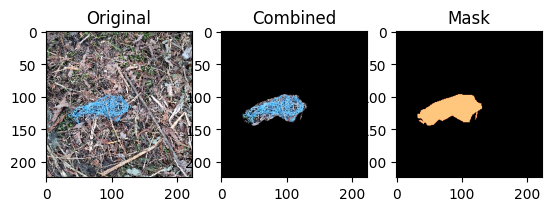

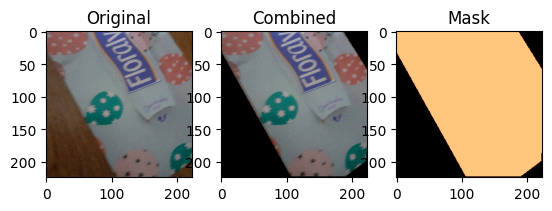

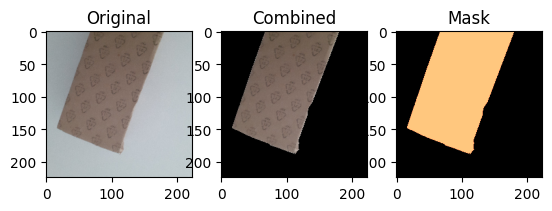

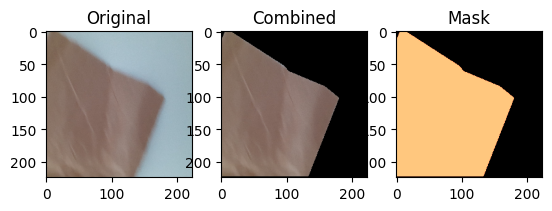

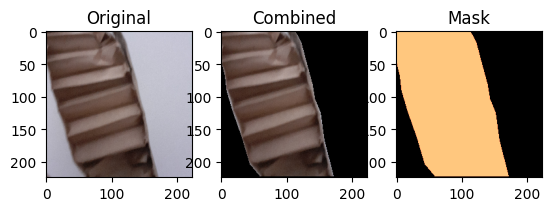

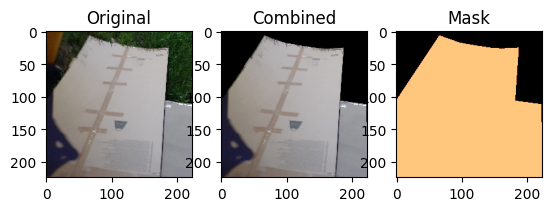

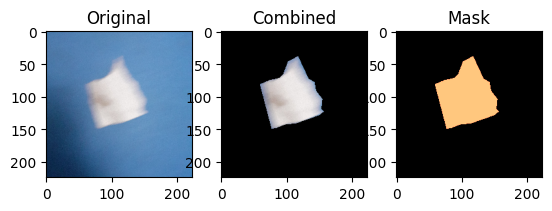

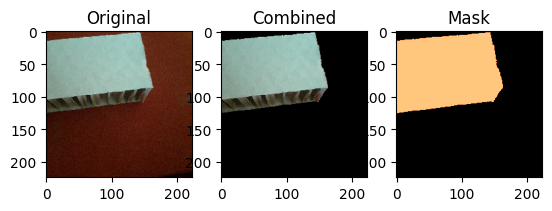

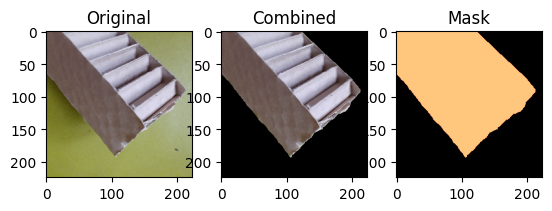

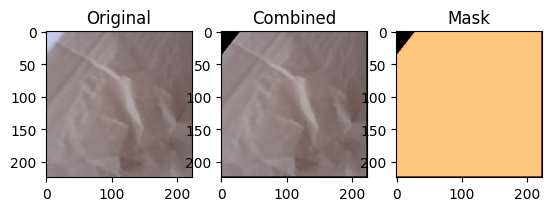

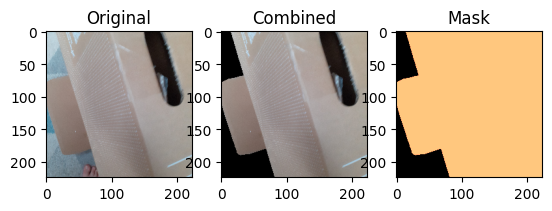

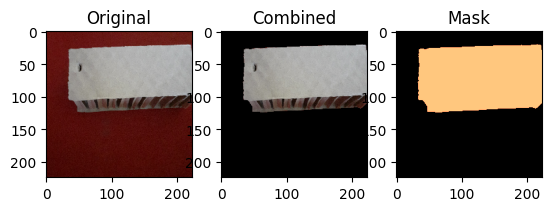

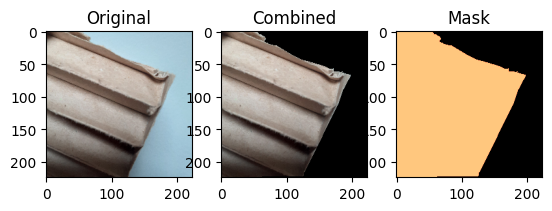

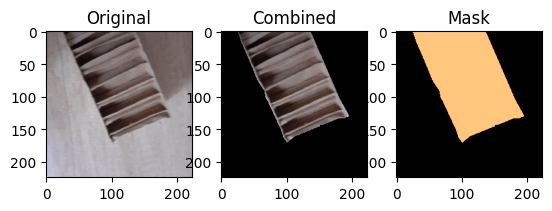

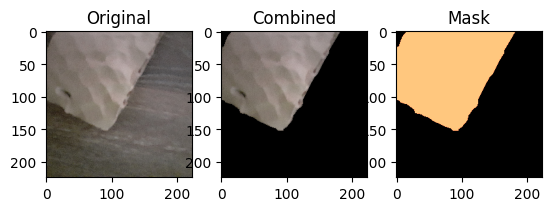

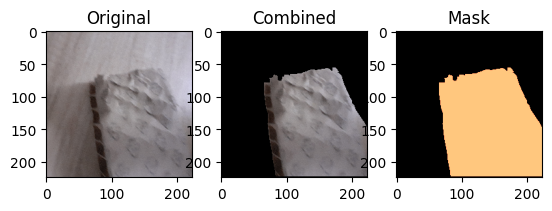

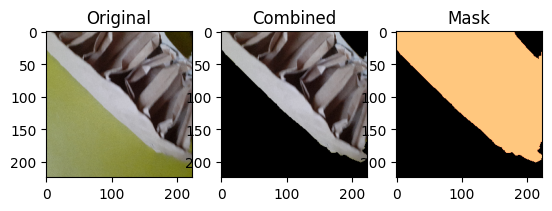

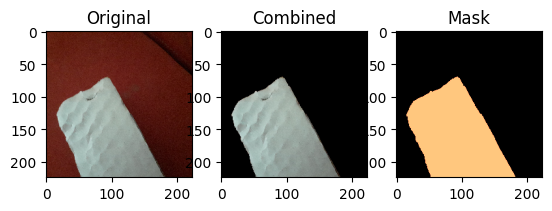

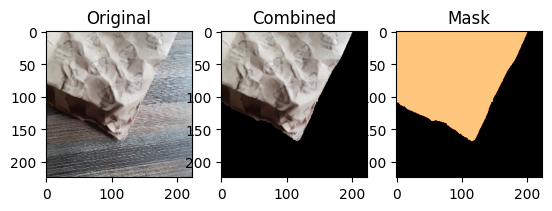

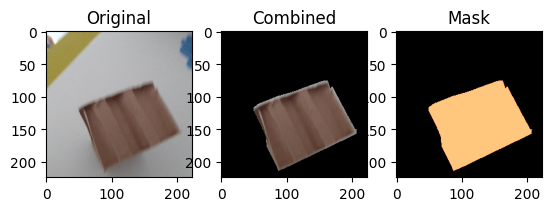

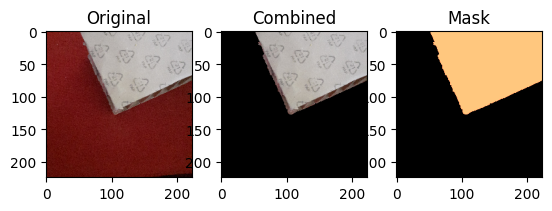

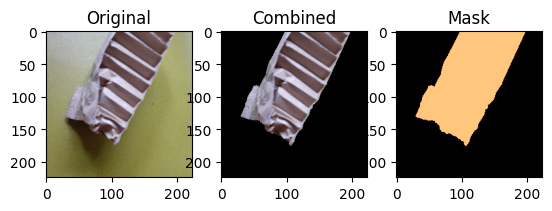

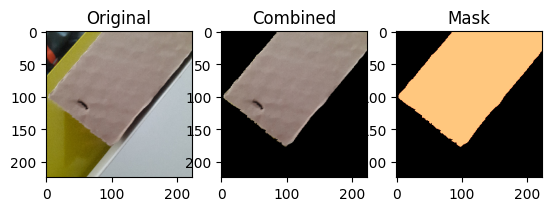

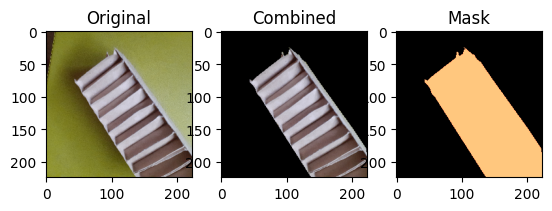

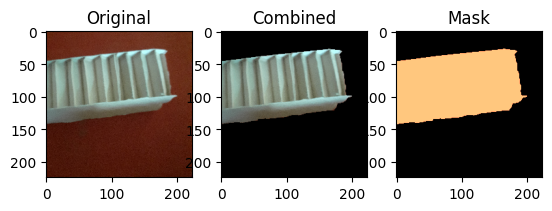

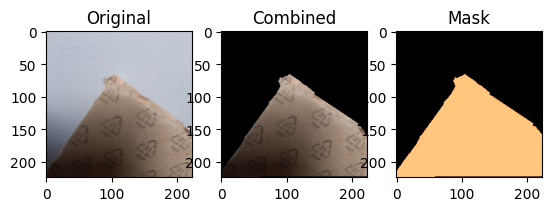

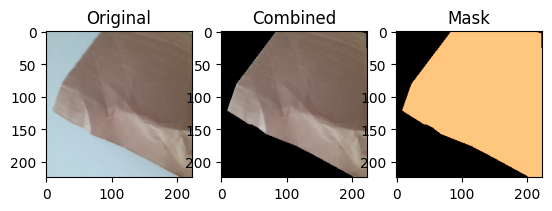

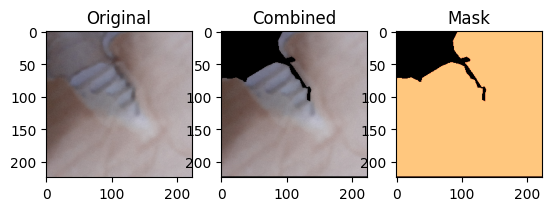

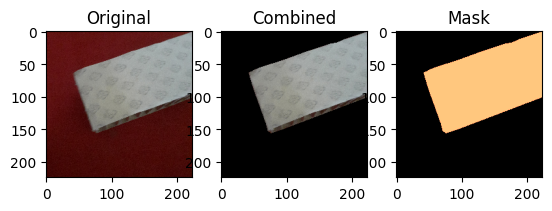

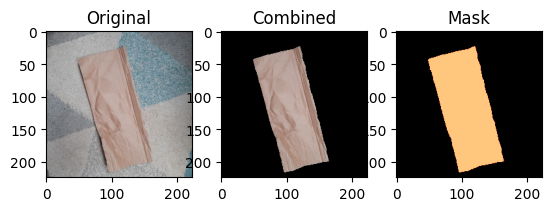

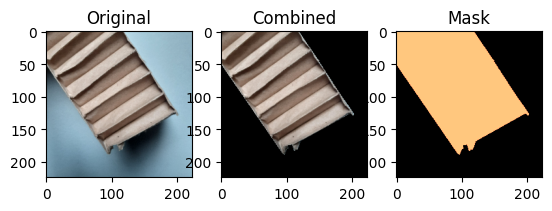

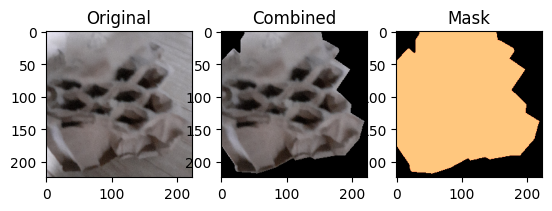

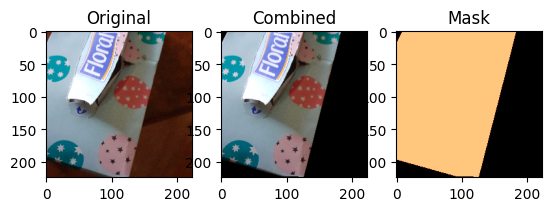

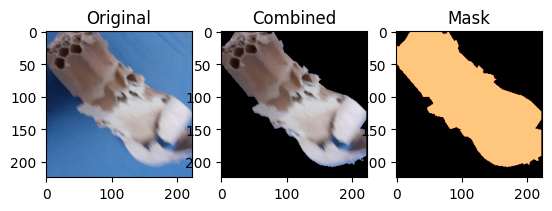

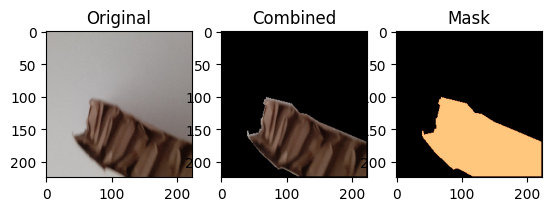

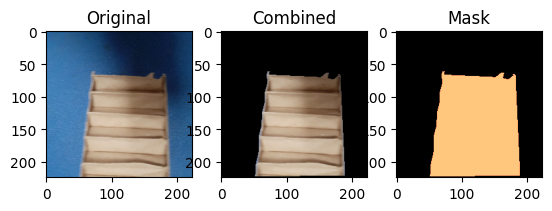

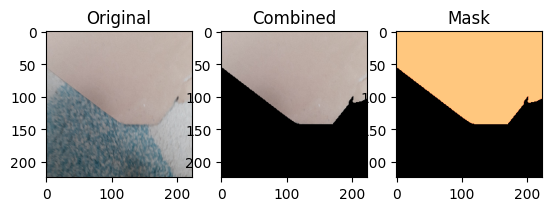

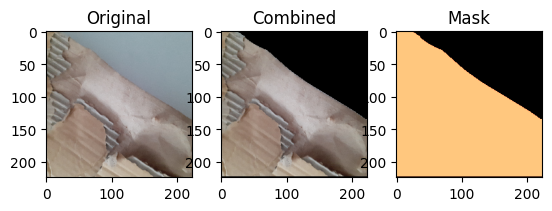

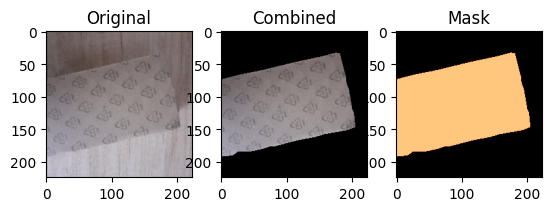

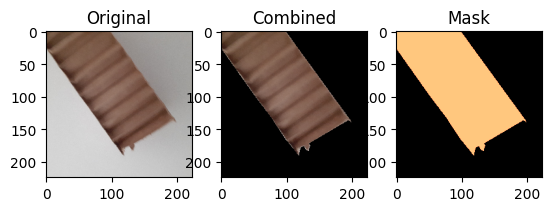

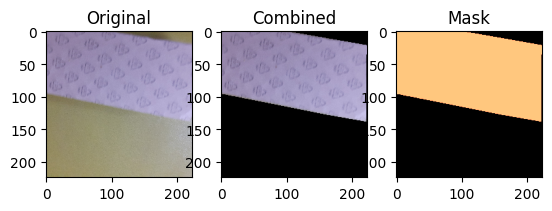

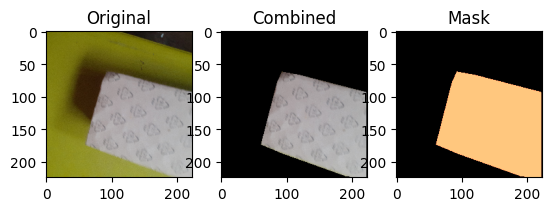

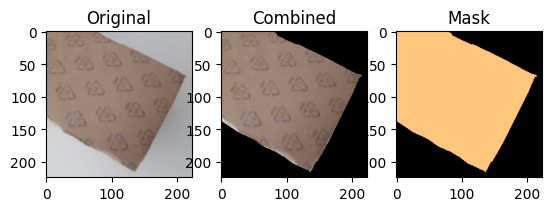

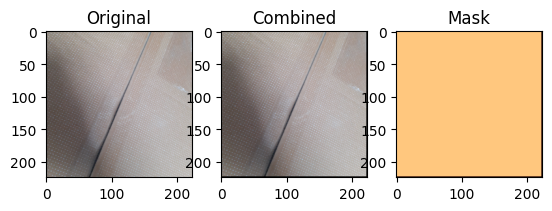

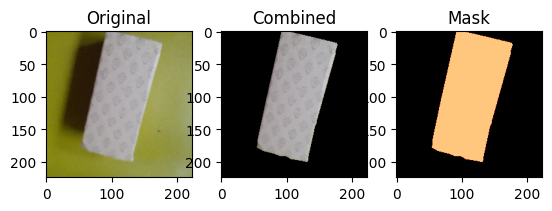

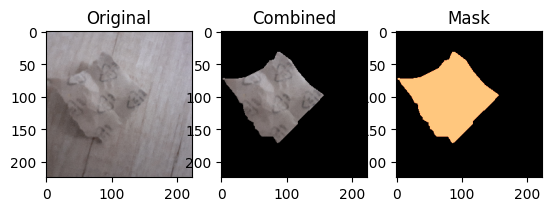

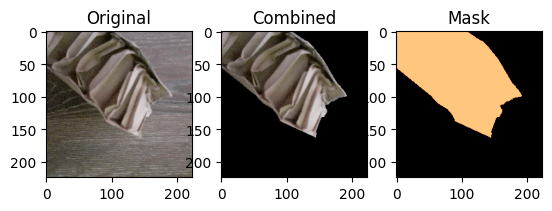

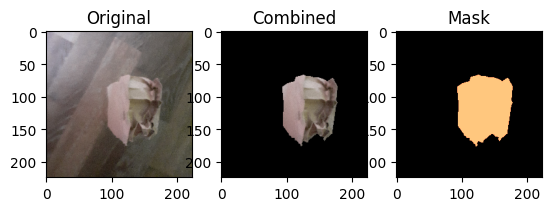

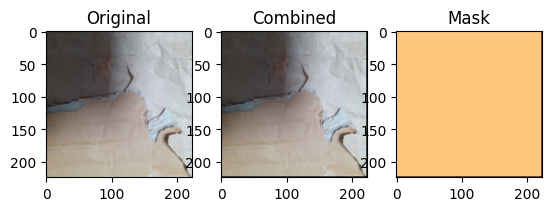

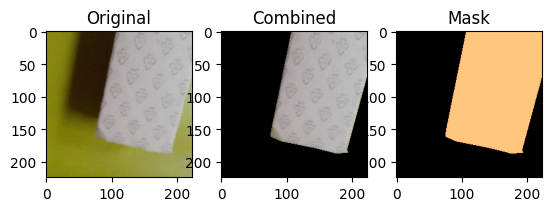

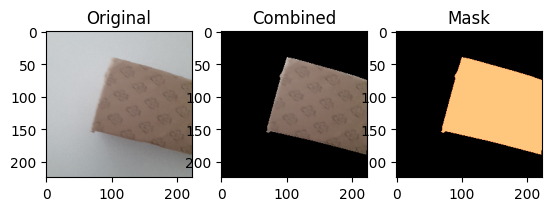

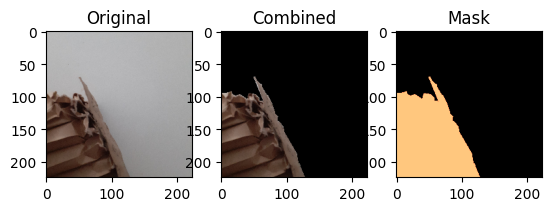

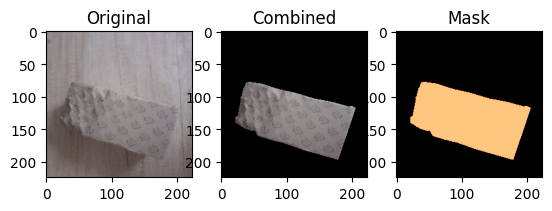

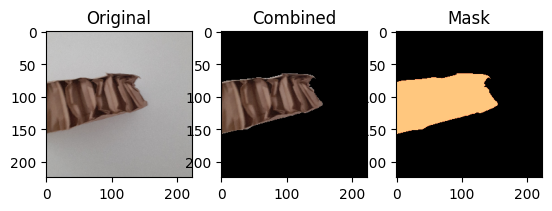

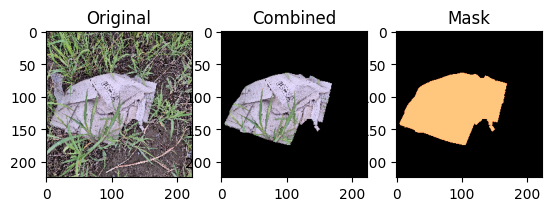

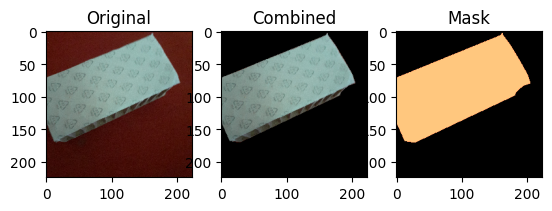

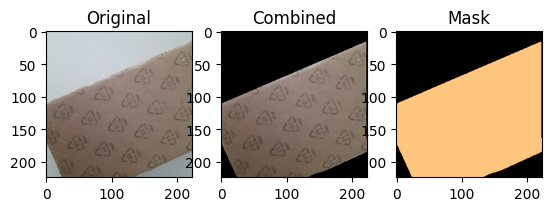

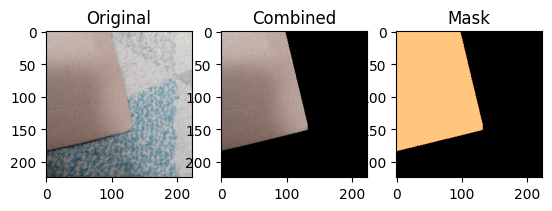

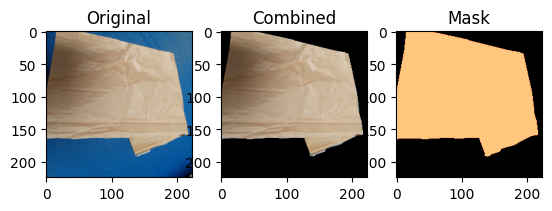

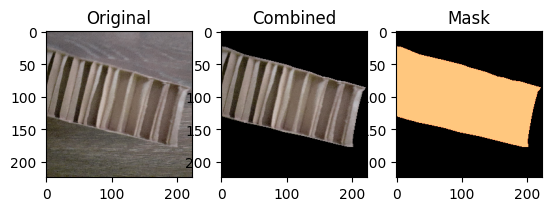

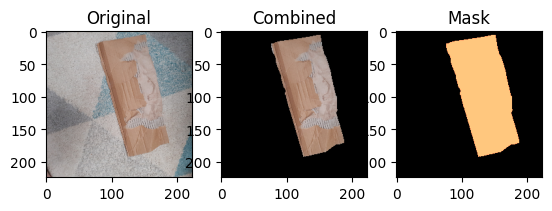

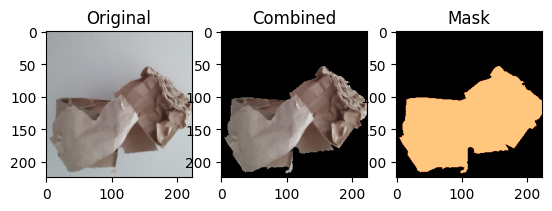

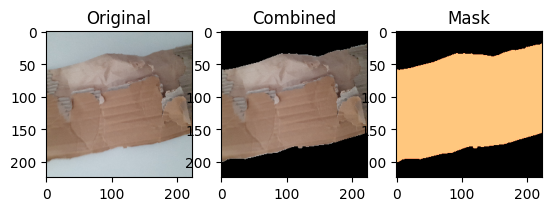

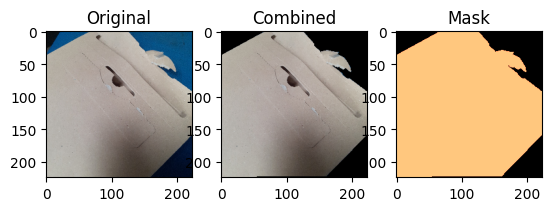

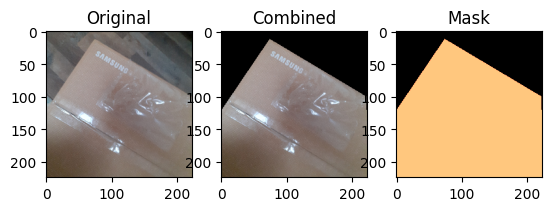

In [ ]:
annotations = []

num_images = len(via_annotations["_via_img_metadata"])
from tqdm.notebook import tqdm  # the progress bar
for i, image_data in tqdm(enumerate(via_annotations["_via_img_metadata"].items()), total=num_images):
    image_info = image_data[1]
    image_id = image_data[0]
    filename = os.path.join(DATA_PATH, image_info["filename"])

    # Load the image
    try:
        img = Image.open(filename)
        # Rotate JPEGs according to the data provided by the camera
        img = ImageOps.exif_transpose(img)
    except:
        print(f"File not found: {filename}. Skipping.")
        continue
    
    WIDTH, HEIGHT = img.size  # original ones
    img = img.resize(IMAGE_RESOLUTION, resample=Image.NEAREST)

    # Create the region mask (1 means transparent)
    if image_info["regions"]:
        mask = Image.new("1", (WIDTH, HEIGHT))
    else:
        # If there aren't any regions, keep the whole image for now
        mask = Image.new("1", (WIDTH, HEIGHT), "white")
    black = Image.new("RGB", IMAGE_RESOLUTION, (0, 0, 0))

    # Extract regions (polygons, circles, rectangles, ellipses) from VIA annotations and draw them on the mask
    for region_info in image_info["regions"]:
        shape_attributes = region_info["shape_attributes"]
        region_shape = shape_attributes["name"]

        pencil = ImageDraw.Draw(mask)

        if region_shape == "polygon":
            points = [(x, y) for x, y in zip(shape_attributes["all_points_x"], shape_attributes["all_points_y"])]
            pencil.polygon(points, "white")

        elif region_shape == "circle":
            x = shape_attributes["cx"]
            y = shape_attributes["cy"]
            r = shape_attributes["r"]
            points = [(x-r, y-r), (x+r, y+r)]
            pencil.ellipse(points, "white")

        elif region_shape == "ellipse":
            ellipse = Image.new("RGBA", IMAGE_RESOLUTION, (0, 0, 0, 0))
            pencil_ellipse = ImageDraw.Draw(ellipse)
            x = shape_attributes["cx"]
            y = shape_attributes["cy"]
            rx = shape_attributes["rx"]
            ry = shape_attributes["ry"]
            angle = shape_attributes["theta"]
            
            # Since ellipses can't be easily rotated in PIL, I'll have to paste a rotated version on top of the mask
            points = [(x-rx, y-ry), (x+rx, y+ry)]
            pencil_ellipse.ellipse(points, "white")
            ellipse = ellipse.rotate(angle, expand=False, center=(x, y))
            mask.paste(ellipse, (0, 0))

        elif region_shape == "rect":
            x = shape_attributes["x"]
            y = shape_attributes["y"]
            w = shape_attributes["width"]
            h = shape_attributes["height"]

            points = [(x, y), (x+w, y+h)]
            pencil.rectangle(points, "white")
    
    # Resize the mask as well
    mask = mask.resize(IMAGE_RESOLUTION, resample=Image.NEAREST)
    
    # Convert them to arrays
    masked = np.asarray(Image.composite(img, black, mask)) / 255.0
    mask = np.asarray(mask) / 255.0
    img = np.asarray(img) / 255.0

    # Plot the three images
    import matplotlib.pyplot as plt
    f, axarr = plt.subplots(1, 3)
    axarr[0].imshow(img)
    axarr[0].set_title("Original")
    
    axarr[1].imshow(masked)
    axarr[1].set_title("Combined")

    axarr[2].imshow(mask, cmap="copper")
    axarr[2].set_title("Mask")

    plt.show()

    # Convert the PIL image to a NumPy array and normalize

    # Get the class label from the directory structure
    class_label = os.path.basename(os.path.dirname(filename))

    # Convert class label to one-hot encoding
    class_index = CLASS_NAMES.index(class_label) # Assuming you have a list of class labels
    class_one_hot = to_categorical(class_index, num_classes=CLASS_COUNT)

    annotations.append((masked, class_one_hot))

# Shuffle the data
shuffle(annotations)

# Convert them to Numpy arrays
images = np.array([i[0] for i in annotations])
labels = np.array([i[1] for i in annotations])


## model definition

In [ ]:
base_model = VGG19(weights="imagenet", include_top=False)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation="relu")(x)
predictions = Dense(CLASS_COUNT, activation="softmax")(x)
model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False


## compilation

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss="categorical_crossentropy",
              metrics=["accuracy"])

## training

In [ ]:
history = model.fit(
    images,
    labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
)

In [ ]:
model.save("model.h5")

## inferencing

In [105]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np

In [106]:
model = load_model("model.h5")

In [120]:
input_image = load_img("tester.jpg", target_size=(224, 224))
input_image = img_to_array(input_image)
input_image = input_image / 255.0
input_image = input_image.reshape((1,) + input_image.shape)

In [121]:
predictions = model.predict(input_image)
predicted_class = np.argmax(predictions, axis=1)[0]
predicted_label = CLASS_NAMES[predicted_class]

1/1 [==============================] - 0s 86ms/step


## plot

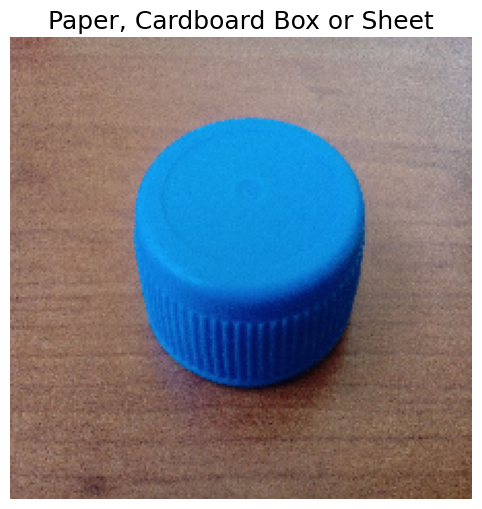

In [122]:
plt.figure(figsize=(8, 6))
plt.imshow(input_image[0])
plt.axis("off")
plt.title(predicted_label, fontsize=18)
plt.show()